## 1. Prepare the data

### 1) Install packages

In [1]:
ssc install qreg2, replace
ssc install coefplot, replace


checking qreg2 consistency and verifying not already installed...
installing into /Users/orangexx/Library/Application Support/Stata/ado/plus/...
installation complete.

checking coefplot consistency and verifying not already installed...
all files already exist and are up to date.


### 2) Load the data

In [2]:
use "https://raw.githubusercontent.com/worldbank/Stata-IE-Visual-Library/develop/Library/Regression%20coefficients/Quantile%20treatment%20effect%20by%20gender/data.dta", clear

(Student Standardized Test Scores)


### 3) Generate dummies for strata (factor variables do not work in 'qreg2')

In [3]:
tab school_strata, gen(school_strata_)


     Strata |      Freq.     Percent        Cum.
------------+-----------------------------------
          1 |      2,158       48.63       48.63
          2 |      1,398       31.50       80.13
          3 |        690       15.55       95.67
          4 |        192        4.33      100.00
------------+-----------------------------------
      Total |      4,438      100.00


## 2. Estimate Coefficients

### 1) Define regression options

In [6]:
local quantileInterval = 0.1
local statSignLevel    = 90

### 2) Initiate locals (to be filled in the next loop)

In [7]:
local quantileLabels   = ""     //x-axis label
local modelsList       = ""     //estimates name
local quantileCount    = 0.5    //manually adapt position in the graph

### 3）Setting quantiles and gender variables

In [10]:
forv quantile = `quantileInterval'(`quantileInterval')`=1-`quantileInterval'' {
     local roundQuantile =  round(real(string(`quantile'*100, "%4.0f")),10)/100
     local integerQuantile = `roundQuantile'*100  // Loops on quantiles
     forv  genderDummy = 0/1 {                    // Loops on gender dummies
           if `genderDummy'   == 0 {
               local genderLab  "F"
               local lineColor  "132 4 252"       //purple
            }
           if `genderDummy'   == 1 {
               local genderLab  "M"
               local lineColor  "4 196 172"       //green
            }                                     // Set color and estimate suffix depending on gender
        eststo est_q`integerQuantile'_`genderLab': ///
         qui qreg2 student_average_std school_treated school_strata* ///
         if student_gender == `genderDummy' ///
         , q(`roundQuantile') cl(school_id)
         local modelsList `"`modelsList' (est_q`integerQuantile'_`genderLab', ciopts(recast(rcap) lcolor("`lineColor'")) mcolor("`lineColor'") ) "'
         }
         local quantileCount  =  0.1 + `quantileCount'
         local quantileLabels `"`quantileLabels' `quantileCount' "Q{sub:`integerQuantile'}""'
}

## 3. Plot graph

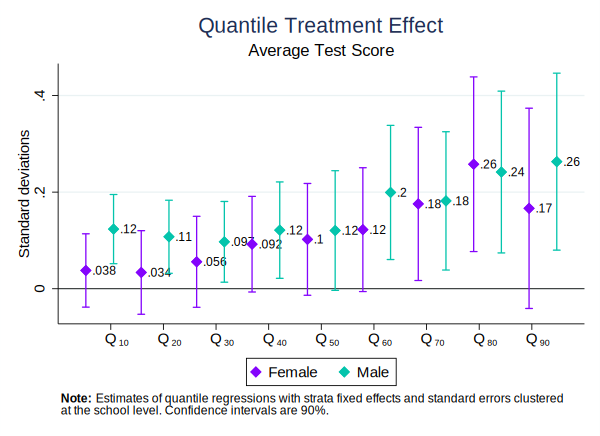

In [23]:
coefplot `modelsList', keep(*school_treated*) bycoefs vertical mlab mlabcolor(black) format(%9.2g) msymbol(diamond) ///
            levels(`statSignLevel') ///
            title("Quantile Treatment Effect") ///
            subtitle("Average Test Score") ///
            ytitle("Standard deviations") ///
            yline(0, lstyle(foreground)) ///
            xlab(none) xlabel(`quantileLabels', add) /// 
            legend(order(2 4) lab(2 "Female") lab(4 "Male")) /// 
            note("{bf:Note:} Estimates of quantile regressions with strata fixed effects and standard errors clustered" "at the school level. Confidence intervals are `statSignLevel'%.") /// 
            graphregion(color(white))

## 4. Export the graph in .png format

In [ ]:
qui graph export "figures.png", width(5000) replace